<h1><center><font size="25">Exploración de la demanda eléctrica con Python</font></center></h1>

<center><b>Ana Georgina Flesia </b></center>
    
  <center><b>  Basado en una notebook de Joaquín Amat Rodrigo y Javier Escobar Ortiz</b></center>



# Introducción
<br>

Una serie temporal (*time series*) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. La recolección de datos indexados temporalmente puede realizarse con diferentes objetivos: predecir el comportamiento de la serie en intervalos de tiempo no muestreados, descomponer la serie en componentes significativas, descubrimiento de eventos raros, caracterización de eventos raros.

Es por eso que hay muchas formas de modelar datos indexados, no necesariamente como series de tiempo. Procesamiento de señales se basa en análisis armónico de los datos, esto es, transformaciones de los datos que crean coeficientes en otros espacios donde se puede estudiar mejor el comportamiento de la serie. Estas transformaciones no modelan paramétricamente los datos, son deterministicas, y se basan en descomposiciones en bases funcionales. 

¿Qué pasa con la parte aleatoria de los datos? Se la ignora? No, pero el estudio es no paramétrico. En este curso solo vamos a considerar estudios paramétricos de los datos. 


## Caso de uso para mostrar un ejemplo muy bonito de exploración
<br>

Se dispone de una serie temporal con la demanda eléctrica (MW) del estado de Victoria (Australia) desde 2011-12-31 al 2014-12-31. Se pretende generar un modelo de *forecasting* capaz de predecir la demanda energética del día siguiente a nivel horario. 
<br>

## Librerías
<br>

Las librerías utilizadas en este documento son:

In [6]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Datos
<br>

Los datos empleados en este documento se han obtenido del paquete de **R** [tsibbledata]("https://tsibbledata.tidyverts.org/"). El set de datos contiene 5 columnas y 52608 registros completos. La información de cada columna es:

+ Time: fecha y hora del registro.

+ Date: fecha del registro

+ Demand: demanda de electricidad MW.

+ Temperature: temperatura en Melbourne, capital del estado de Victoria.

+ Holiday: indicador si el día es festivo (vacaciones).

### Descarga de datos

In [7]:
datos = pd.read_csv('vic_elec.csv', sep=',')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


### Manejo del indice temporal

Es importante estudiar, al importar un conjunto de datos indexados en tiempo, que información del muestreo de los datos contiene el dataset. Por ello, suele haber una variable llamada tiempo o fechas o algo por el estilo que hace referencia a ese muestreo. Puede haber datos faltantes, puede haber datos duplicados, esto último ocurre cuando se retrasa o se adelanta la hora en alguna época del año.  

En este dataset, la columna *Time* se ha almacenado como `string`. Para convertirla en `datetime`, se emplea la función `pd.to_datetime()`. Una vez en formato `datetime`, y para hacer uso de las funcionalidades de **pandas**, se establece como índice. Además, dado que los datos se han registrado cada 30 minutos, se indica la frecuencia ('30min').

In [8]:
# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()

Uno de los primeros análisis que hay que realizar al trabajar con series temporales es verificar si la serie está completa, esto es, no hay registros temporales faltantes o duplicados.

In [9]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

In [10]:
# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)

### Manejo del muestreo

En muchos casos, los datos tienen una frecuencia mayor a la que se quiere estudiar, o en la frecuencia de muestreo dada, la variabilidad es muy alta por lo cual un suavizado mediante acumulacion de informacion es aconsejable.

En nuestro caso, los datos se encuentran en intervalos de 30 minutos, y se desea trabajar con la demanda eléctrica a nivel horario, por lo que se tienen que promediar los datos en el intervalo deseado para generar un único valor. Este tipo de transformación es muy sencilla si se combina el índice de tipo temporal de pandas y su método `resample()`. 

Es muy importante utilizar correctamente los argumentos `closed='left'` y `label='right'` para no introducir en el entrenamiento información a futuro ([*leakage*](https://en.wikipedia.org/wiki/Leakage_(machine_learning))). Supóngase que se dispone de valores para las 10:10, 10:30, 10:45, 11:00, 11:12 y 11:30. Si se quiere obtener el promedio horario, el valor asignado a las 11:00 debe calcularse utilizando los valores de las 10:10, 10:30 y 10:45; y el de las 12:00, con el valor de las 11:00, 11:12 y 11:30.

Diagrama de acumulación de datos temporales sin incluir información de futuro

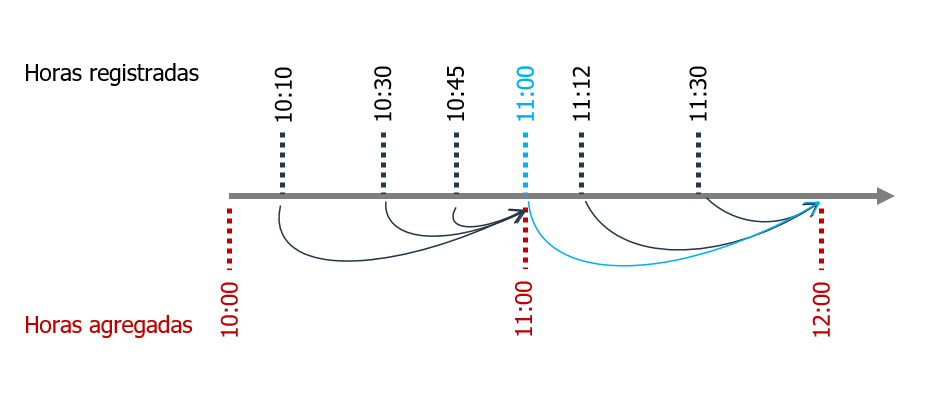

In [11]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "diagrama_resampling_datetime.PNG", width=600)

Para el valor promedio de las 11:00 no se incluye el valor puntual de las 11:00 por que, en la realidad, en ese momento exacto no se dispone todavía del valor.

In [12]:
# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al acumular. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


### Particion de los datos en conjuntos de entrenamiento, validacion y test

Es muy importante distinguir la forma en que se trabaja en series de tiempo, de la que se utiliza en aprendizaje supervizado, a la hora de dividir los datos en conjuntos de entrenamiento, validación y test. No se eligen al azar!!! 

Las series de tiempo son correlacionadas. Aún cuando uno las considere funciones deterministicas y no trayectorias de un proceso estocástico, no tiene sentido elegir puntos de la curva al azar. Se eligen sectores consecutivos.

El set de datos empieza el *2011-12-31 14:00:00* y termina el *2014-12-31 13:00:00*. Se descartan los primeros 10 y los últimos 13 registros para que empiece el *2012-01-01 00:00:00* y termine el *2014-12-30 23:00:00*. Además, para poder optimizar los hiperparámetros del modelo y evaluar su  capacidad predictiva, se dividen los datos en 3 conjuntos, uno de entrenamiento, uno de validación y otro de test.

In [13]:
# Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
fin_train = '2013-12-31 23:59:00'
fin_validacion = '2014-11-30 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Fechas validacion : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Fechas test       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


## Exploración gráfica
<br>

Cuando se quiere generar un modelo de *forecasting*, es importante representar los valores de la serie temporal. Esto permite identificar patrones tales como tendencias y estacionalidad.

**Serie temporal completa**

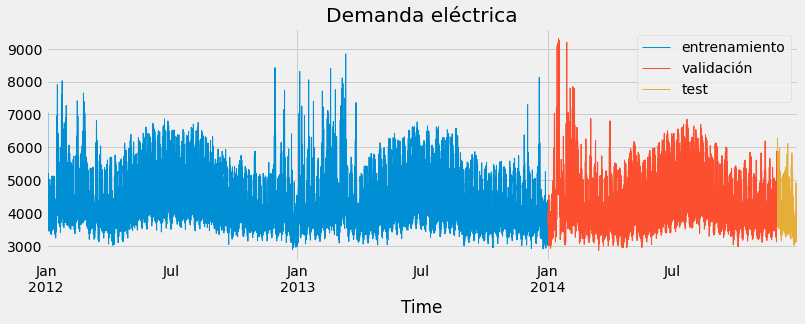

In [14]:
# Gráfico serie temporal
# ==============================================================================
#plt.style.use('default')
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demand.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demand.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

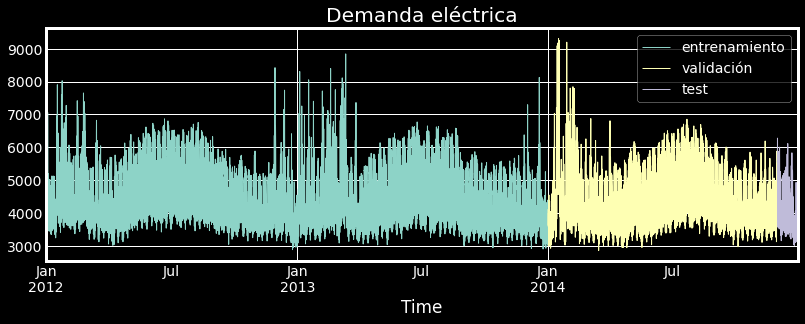

In [15]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demand.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demand.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

### ¿Que vemos en este gráfico?

El gráfico anterior muestra que 

- la demanda eléctrica tiene estacionalidad anual;  
- hay un incremento centrado en el mes de Julio 
- hay picos de demanda muy acentuados entre enero y marzo.
- no es posible apreciar si existen patrones del orden de un día.


**Sección de la serie temporal**

Debido a la varianza de la serie temporal, no es posible apreciar con un solo gráfico el posible patrón intradiario. En cronobiología, los patrones asociados a los ciclos solares se llaman circadianos y ultradianos. Como la energía eléctrica es consumida por humanos, que siguen un ciclo circadiano, es de esperar la presencia de este ciclo en la serie. Mas interesantes son los ciclos semanales o los ciclos dentro del día. 

Para explorar la serie en las escalas ultradianas, es necesario hacer diferentes zooms.

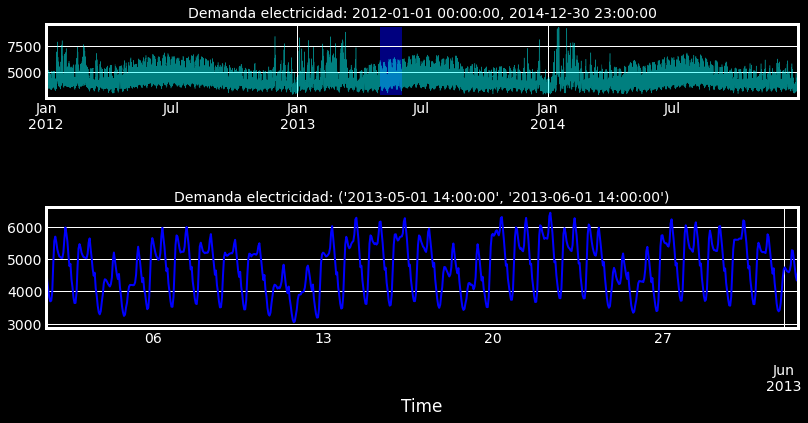

In [16]:

# Gráfico serie temporal con zoom
# ==============================================================================
#plt.style.use('Solarize_Light2')
#plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos.Demand.plot(ax=main_ax, c='cyan', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demand)
max_y = max(datos.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

datos.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

### ¿Que vemos en este gráfico de zoom?

Al aplicar zoom sobre la serie temporal, se observa
- una clara estacionalidad semanal, 
- consumos más elevados durante la semana laboral (lunes a viernes) 
- y menor consumo en los fines de semana. 

Se observa también que existe una clara correlación entre el consumo de un día con el del día anterior.


### Estacionalidad anual, semanal y diaria

**Estacionalidad anual**

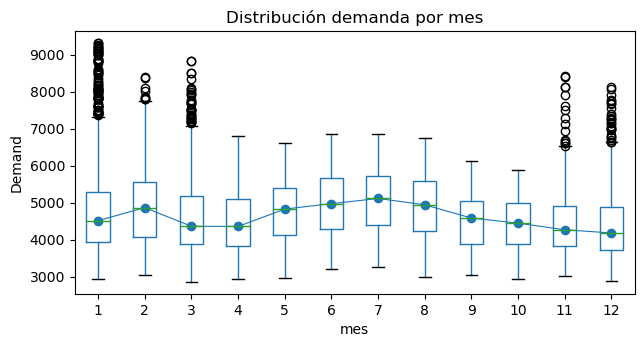

In [17]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
plt.style.use('default')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demand', by='mes', ax=ax,)
datos.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

Se observa que hay una estacionalidad anual, con valores de demanda (mediana) superiores en los meses de Junio, Julio y Agosto, y con elevados picos de demanda en los meses de Noviembre, Diciembre, Enero, Febrero y Marzo.

**Estacionalidad semanal**

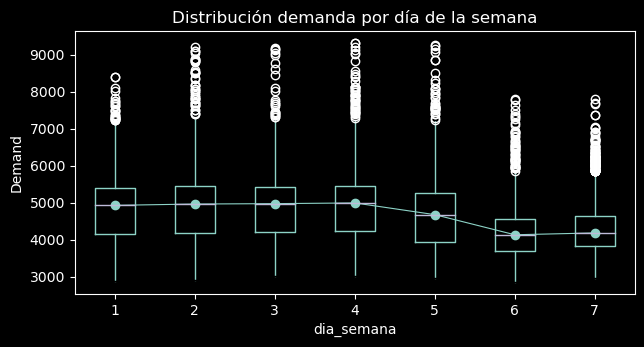

In [18]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['dia_semana'] = datos.index.day_of_week + 1
datos.boxplot(column='Demand', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

Se aprecia una estacionalidad semanal, con valores de demanda inferiores durante el fin de semana.
<br><br>

**Estacionalidad diaria**

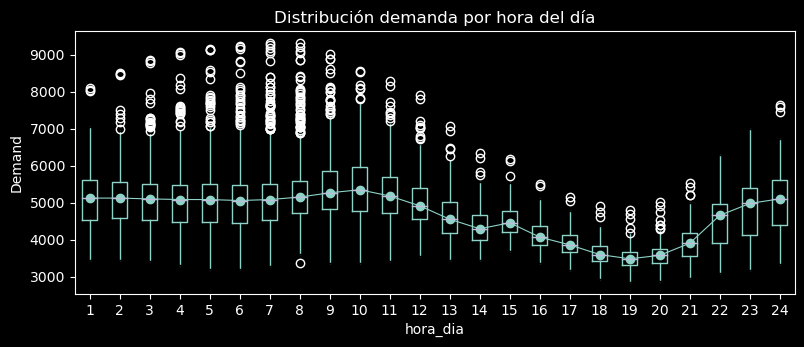

In [19]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

También existe una estacionalidad diaria, la demanda se reduce entre las 16 y las 21 horas.
<br><br>

**Días festivos y no festivos**

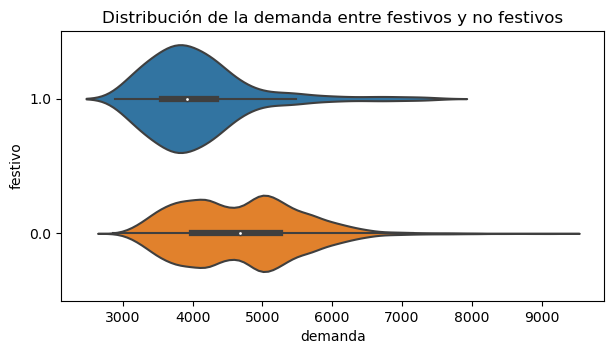

In [20]:
# Grafico violinplot
# ==============================================================================
plt.style.use('default') #plt.style.use('Solarize_Light2')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos.assign(Holiday = datos.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

Los días festivos tienden a tener menor consumo.
<br><br>

**Esta notebook esta basada en el siguiente documento**

<p style="text-align:left"><font size="3" color="#555">
Predicción (forecasting) de la demanda eléctrica con Python by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py29-forecasting-demanda-energia-electrica-python.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo and Javier Escobar Ortiz is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.